In [33]:
!pip install dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 50.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 77.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
  

In [34]:
import dagshub
dagshub.init(repo_owner='nmach22', repo_name='house-prices-ml', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=92ad08c7-dac3-4ba1-b210-9998d6990bd5&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=453ba3658765c0a969bd977bd783a1f0960445d60a7dbc61d32209233038c96f




Accessing as nmach22

Initialized MLflow to track repo "nmach22/house-prices-ml"

Repository nmach22/house-prices-ml initialized!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [87]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [4]:
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.shape

(1460, 81)

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 80), (292, 80), (1168,), (292,))

In [97]:
X_train.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       217
LotArea             0
Street              0
Alley            1094
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        683
MasVnrArea          6
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           28
BsmtCond           28
BsmtExposure       28
BsmtFinType1       28
BsmtFinSF1          0
BsmtFinType2       28
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [94]:
# X_train_ids = X_train.pop('Id')
# X_test_ids = X_test.pop('Id')
# test_df_ids = test_df.pop('Id')

In [9]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

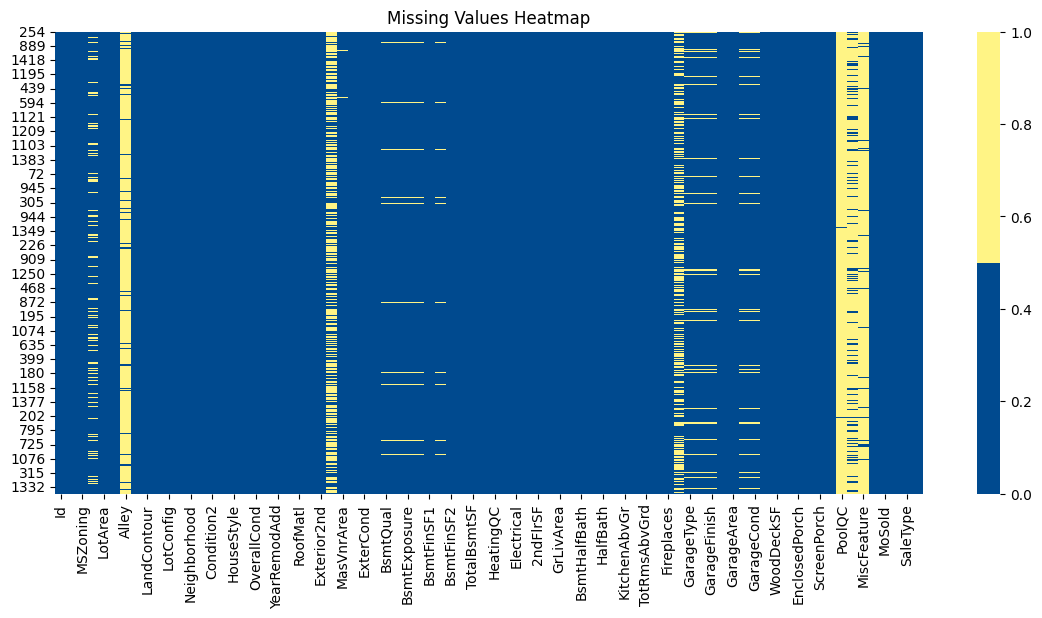

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# vizulize what's missing
plt.figure(figsize=(14, 6))

colors = ['#004a8f', '#FFF485']
sns.heatmap(X_train.isna(), cmap=sns.color_palette(colors))

plt.title("Missing Values Heatmap")
plt.show()

In [11]:
del_cols = ['Id']
del_cols += [col for col in X_train.columns if X_train[col].isna().sum() > 500]

In [12]:
del_cols

['Id', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [ ]:
for col in cat_cols:
    print(X_train[col].value_counts())

### WOE encoding

In [13]:
s = X_train[cat_cols].nunique()
print(len(s) + len(num_cols))
s

80


MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
MasVnrType        3
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        4
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [14]:
threshold = 3

woe_columns = list(s[s > threshold].index)
one_hot_columns = list(s[s <= threshold].index)

## Preprocess

In [15]:
X_train[woe_columns].mode().T[0].to_dict()

{'MSZoning': 'RL',
 'LotShape': 'Reg',
 'LandContour': 'Lvl',
 'LotConfig': 'Inside',
 'Neighborhood': 'NAmes',
 'Condition1': 'Norm',
 'Condition2': 'Norm',
 'BldgType': '1Fam',
 'HouseStyle': '1Story',
 'RoofStyle': 'Gable',
 'RoofMatl': 'CompShg',
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'ExterQual': 'TA',
 'ExterCond': 'TA',
 'Foundation': 'PConc',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Heating': 'GasA',
 'HeatingQC': 'Ex',
 'Electrical': 'SBrkr',
 'KitchenQual': 'TA',
 'Functional': 'Typ',
 'FireplaceQu': 'Gd',
 'GarageType': 'Attchd',
 'GarageQual': 'TA',
 'GarageCond': 'TA',
 'Fence': 'MnPrv',
 'MiscFeature': 'Shed',
 'SaleType': 'WD',
 'SaleCondition': 'Normal'}

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns, del_cols):
        self.woe_columns = list(set(woe_columns) - set(del_cols))
        self.one_hot_columns = list(set(one_hot_columns) - set(del_cols))

        self.del_cols = del_cols

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        self.num_cols = [col for col in X.columns if X[col].dtype != 'object' and col != 'Id']
        
        df_woe = X.copy()
        target_col = 'SalePrice'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        # Store one-hot encoded columns
        X_temp = pd.get_dummies(X[self.one_hot_columns], columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)
        self.one_hot_encoded_columns = X_temp.columns

        return self


    def transform(self, X):
        X_transformed = X.copy()
        #Delete unwanted columns
        X_transformed = X_transformed.drop(columns = self.del_cols)
        
        # Preprocess WOE Columns
        print("***")
        
        print("Fill NaNs in numerical columns with 0-s")
        for col in self.num_cols:
            X_transformed[col] = X_transformed[col].fillna(0)
        
        print("Preprocessing WOE Columns")
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        print("Preprocessing One Hot Columns")
        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)

        # Reindex to ensure consistent columns
        X_transformed = X_transformed.reindex(columns=X_transformed.columns.union(self.one_hot_encoded_columns), fill_value=0)
        X_transformed = X_transformed[self.one_hot_encoded_columns.union(X_transformed.columns)]

        print("Check Nans")
        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)

        print(na_cols)

        for col in na_cols:
            name, pr = col.split("_")
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])

            print(col, name, pr, dic[name], mappings[name][dic[name]])
            
        return X_transformed

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

pipeline = Pipeline([
    ('preprocess', CustomPreprocessor(woe_columns=woe_columns, one_hot_columns=one_hot_columns, del_cols=del_cols)),
    ('scaler', StandardScaler()),
    ('model', model)
])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).squeeze()

# Fit the pipeline on the entire training set
pipeline.fit(X_train, y_train_scaled)

preds_validation = pipeline.predict(X_test)
preds_test = pipeline.predict(test_df)

pred = y_scaler.inverse_transform(preds_test.reshape(-1, 1))

Processing LotConfig...
Processing Condition1...
Processing SaleType...
Processing GarageQual...
Processing ExterQual...
Processing BsmtFinType1...
Processing BsmtCond...
Processing LandContour...
Processing HouseStyle...
Processing RoofStyle...
Processing Neighborhood...
Processing Heating...
Processing GarageType...
Processing Electrical...
Processing BsmtFinType2...
Processing RoofMatl...
Processing BsmtExposure...
Processing LotShape...
Processing Condition2...
Processing BsmtQual...
Processing SaleCondition...
Processing Foundation...
Processing HeatingQC...
Processing BldgType...
Processing MSZoning...
Processing ExterCond...
Processing Functional...
Processing KitchenQual...
Processing GarageCond...
Processing Exterior1st...
Processing Exterior2nd...
***
Fill NaNs in numerical columns with 0-s
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['BsmtCond_woe', 'BsmtExposure_woe', 'BsmtFinType1_woe', 'BsmtFinType2_woe', 'BsmtQual_woe', 'Electrical_woe', 'GarageCon

In [38]:
model.coef_

82

In [19]:
# Transform the training data to see the scaled result
X_train_transformed = pipeline.named_steps['preprocess'].transform(X_train)
X_train_scaled = pipeline.named_steps['scaler'].transform(X_train_transformed)

# Convert the scaled data to a DataFrame for easier viewing
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_transformed.columns)

***
Fill NaNs in numerical columns with 0-s
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['BsmtCond_woe', 'BsmtExposure_woe', 'BsmtFinType1_woe', 'BsmtFinType2_woe', 'BsmtQual_woe', 'Electrical_woe', 'GarageCond_woe', 'GarageQual_woe', 'GarageType_woe']
BsmtCond_woe BsmtCond woe TA 0.42856122790761614
BsmtExposure_woe BsmtExposure woe No 0.0
BsmtFinType1_woe BsmtFinType1 woe Unf 0.0
BsmtFinType2_woe BsmtFinType2 woe Unf 0.5619048032113009
BsmtQual_woe BsmtQual woe TA 0.0
Electrical_woe Electrical woe SBrkr 6.2073637697093815
GarageCond_woe GarageCond woe TA 0.42769141616391054
GarageQual_woe GarageQual woe TA 0.3319878171389898
GarageType_woe GarageType woe Attchd 1.7822520564258728


In [20]:
X_train_scaled_df.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType_woe,BsmtCond_woe,BsmtExposure_woe,BsmtFinSF1,BsmtFinSF2,BsmtFinType1_woe,...,Street_Pave,Street_nan,TotRmsAbvGrd,TotalBsmtSF,Utilities_NoSeWa,Utilities_nan,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03,...,1.168000e+03,1168.0,1.168000e+03,1.168000e+03,1.168000e+03,1168.0,1.168000e+03,1.168000e+03,1.168000e+03,1.168000e+03
mean,-1.885858e-16,9.125121e-18,-1.672939e-17,-6.083414e-18,2.433366e-17,-6.083414e-17,-5.779243e-17,1.520853e-17,-2.433366e-17,1.779399e-16,...,2.509408e-16,0.0,-1.825024e-17,2.037944e-16,6.083414e-18,0.0,-6.159457e-17,-1.420477e-15,4.641645e-15,6.597006e-14
std,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00,...,1.000428e+00,0.0,1.000428e+00,1.000428e+00,1.000428e+00,0.0,1.000428e+00,1.000428e+00,1.000428e+00,1.000428e+00
min,-2.161277e+00,-8.019229e-01,-1.210081e-01,-3.592758e+00,-3.093294e-01,-9.163811e-01,-6.370641e-01,-9.719957e-01,-2.855041e-01,-6.248809e-01,...,-1.705872e+01,0.0,-2.817548e+00,-2.410445e+00,-2.927282e-02,0.0,-7.401575e-01,-3.227597e+00,-1.683818e+00,-1.375486e+00
25%,-7.279363e-01,-8.019229e-01,-1.210081e-01,-1.106774e+00,-3.093294e-01,-1.944300e-01,-6.370641e-01,-9.719957e-01,-2.855041e-01,-6.248809e-01,...,5.862104e-02,0.0,-9.645659e-01,-6.033572e-01,-2.927282e-02,0.0,-7.401575e-01,-5.859221e-01,-9.118065e-01,-6.190983e-01
50%,-1.923741e-01,-8.019229e-01,-1.210081e-01,1.362183e-01,-3.093294e-01,-1.944300e-01,-6.370641e-01,-1.340758e-01,-2.855041e-01,-6.248809e-01,...,5.862104e-02,0.0,-3.469053e-01,-1.459097e-01,-2.927282e-02,0.0,-7.401575e-01,3.373017e-02,4.392138e-01,1.372896e-01
75%,5.883308e-01,8.549472e-01,-1.210081e-01,1.362183e-01,-3.093294e-01,-1.944300e-01,6.400131e-01,5.992403e-01,-2.855041e-01,1.600305e+00,...,5.862104e-02,0.0,2.707553e-01,5.391266e-01,-2.927282e-02,0.0,5.558347e-01,9.795152e-01,9.217210e-01,8.936774e-01
max,9.113990e+00,3.897853e+00,1.600282e+01,6.351179e+00,3.239581e+00,4.459611e+00,2.327862e+00,1.132767e+01,6.840653e+00,1.600305e+00,...,5.862104e-02,0.0,4.594380e+00,1.146055e+01,3.416138e+01,0.0,5.870946e+00,1.273035e+00,1.211225e+00,1.650065e+00


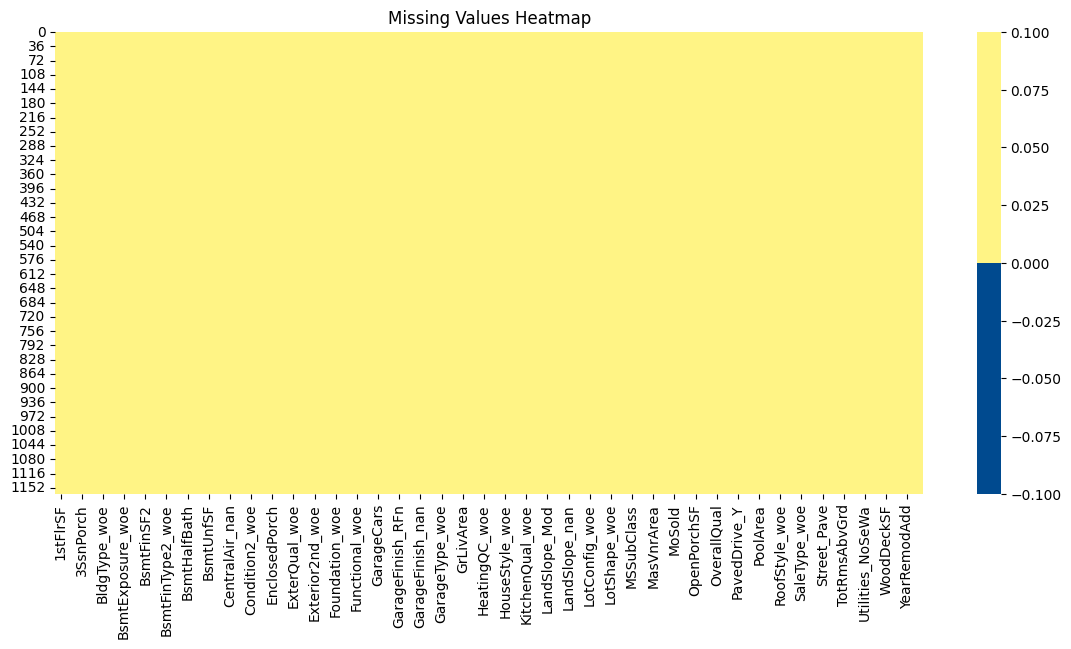

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# vizulize what's missing
plt.figure(figsize=(14, 6))

colors = ['#004a8f', '#FFF485']
sns.heatmap(X_train_scaled_df.isna(), cmap=sns.color_palette(colors))

plt.title("Missing Values Heatmap")
plt.show()

In [22]:
X_train_scaled_df.isna().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
BedroomAbvGr     0
BldgType_woe     0
                ..
Utilities_nan    0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
YrSold           0
Length: 82, dtype: int64

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, preds_validation))
mae = mean_absolute_error(y_test, preds_validation)
r2 = r2_score(y_test, preds_validation)

print(f'rmse = {rmse}; mae = {mae}, r2 = {r2}')

rmse = 199132.81465687364; mae = 178839.8913774034, r2 = -4.16977724311294


In [25]:
len(preds_test)

1459

In [26]:
experiment_name = "linear_Regression_Pipeline"
run_name="linear_regression_with_scaled_output_while_training"

In [39]:
import mlflow

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):
    mlflow.log_param("fillna_value", 0)
    mlflow.log_param("model_name", "LinearRegression")

    mlflow.log_param("woe_columns_count", len(woe_columns))
    mlflow.log_param("one_hot_columns_count", len(one_hot_columns))

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(model, "linear_regression_model")
    print(f"Logged run_id: {mlflow.active_run().info.run_id}")

2025/04/02 07:56:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged run_id: 63e447604fbb43a6af41be9f05a6ab3c
🏃 View run linear_regression_with_scaled_output_while_training at: https://dagshub.com/nmach22/house-prices-ml.mlflow/#/experiments/1/runs/63e447604fbb43a6af41be9f05a6ab3c
🧪 View experiment at: https://dagshub.com/nmach22/house-prices-ml.mlflow/#/experiments/1


In [40]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Generate Submission file

In [222]:
submission = pd.DataFrame({
    'Id': test_df_ids,
    'SalePrice': pred.squeeze()
})

# Save to CSV
submission.to_csv('submission.csv', index=False)